# Análise de Vendas de Cafeteria: Estratégia de Receita e Previsão de Demanda


# 1. Introdução

Neste projeto, realizo uma análise exploratória dos dados de vendas de uma cafeteria utilizando um conjunto de dados disponível no Kaggle¹. O objetivo é compreender padrões de consumo ao longo de um ano, identificar os produtos mais relevantes para o faturamento, observar tendências temporais e gerar insights que possam apoiar decisões de negócio.


O dataset contém transações entre **março/2024 e fevereiro/2025**, com informações como:
- data e horário da venda,
- tipo de café,
- preço,
- quantidade,
- forma de pagamento.

Ao longo da análise, busco responder perguntas como:
- Quais produtos mais geram receita?
- Existem períodos de maior ou menor movimento?
- Como o comportamento do cliente muda ao longo do dia?
- Há sazonalidade mensal ou semanal?
- Qual a participação das formas de pagamento?


A estrutura do notebook segue uma linha simples, clara e direta, adequada para recrutadores acompanharem o raciocínio e a metodologia aplicada.

¹ Kaggle Dataset:
https://www.kaggle.com/datasets/ihelon/coffee-sales


# 2. Importação das Bibliotecas

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de estilo para os gráficos
sns.set(style="whitegrid")

# 3. Carregamento e Visão Geral do Dataset

Nesta etapa, monto o Google Drive faço a importação do CSV. Após verifico o tamanho do dataset, visualizo as primeiras linhas e identifico possíveis inconsistências iniciais nos dados.


In [175]:
# Acesso ao Google Drive para acessar os arquivos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [176]:
# Carregar o dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/Coffee_Sales/index_1.csv'
df1 = pd.read_csv(file_path)

In [177]:
print("Dataset preview:")
df1.head()

Dataset preview:


,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [178]:
# informações gerais: colunas, tipos, valores nulos
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3636 non-null   object 
 1   datetime     3636 non-null   object 
 2   cash_type    3636 non-null   object 
 3   card         3547 non-null   object 
 4   money        3636 non-null   float64
 5   coffee_name  3636 non-null   object 
dtypes: float64(1), object(5)
memory usage: 170.6+ KB


# 4. Limpeza e Preparação dos Dados

Nesta etapa, realizo etapas essenciais de tratamento:

- conversão de colunas para os tipos adequados,  
- criação de colunas temporais (ano, mês, dia da semana, horário),  
- verificação da coluna **cash_type**,
- verificação de valores ausentes.


### 4.1 Conversão de Datas

In [179]:
df1['date'] = pd.to_datetime(df1['date'])
df1['datetime'] = pd.to_datetime(df1['datetime'])

### 4.2 Criação de Colunas Temporais


In [180]:
df1['day'] = df1['datetime'].dt.date
df1['weekday'] = df1['datetime'].dt.day_name()
df1['month'] = df1['datetime'].dt.to_period('M')
df1['hour'] = df1['datetime'].dt.hour

### 4.3 Verificação da Coluna 'cash_type'

In [181]:
print(df1['cash_type'].value_counts())
print()
print(df1['cash_type'].value_counts(normalize=True))

cash_type
card    3547
cash      89
Name: count, dtype: int64

cash_type
card    0.975523
cash    0.024477
Name: proportion, dtype: float64


A análise indica uma clientela majoritariamente digital, o que é relevante para estratégias de operação e caixa.

### 4.4 Verificação de Valores Ausentes

In [182]:
print(df1.isna().sum())

date            0
datetime        0
cash_type       0
card           89
money           0
coffee_name     0
day             0
weekday         0
month           0
hour            0
dtype: int64


A coluna `card` contém alguns valores ausentes, o que é esperado, pois são as 89 transações feitas em dinheiro analisadas anteriormente. Esses valores ausentes **não comprometem o resultado**, serão mantidos sem necessidade de imputação ou remoção de linhas.

### 4.5 Verificação Geral após a Limpeza

In [183]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         3636 non-null   datetime64[ns]
 1   datetime     3636 non-null   datetime64[ns]
 2   cash_type    3636 non-null   object        
 3   card         3547 non-null   object        
 4   money        3636 non-null   float64       
 5   coffee_name  3636 non-null   object        
 6   day          3636 non-null   object        
 7   weekday      3636 non-null   object        
 8   month        3636 non-null   period[M]     
 9   hour         3636 non-null   int32         
dtypes: datetime64[ns](2), float64(1), int32(1), object(5), period[M](1)
memory usage: 270.0+ KB


## 5. Análise Exploratória dos Dados (EDA)

A EDA está dividida em blocos temáticos para facilitar o entendimento e leitura.




### 5.1 Análise de Produto: Vendas por Tipo de Café

Nesta etapa, verifico quais cafés foram mais vendidos ao longo do período analisado. Essa informação ajuda a entender a demanda de cada produto e pode orientar decisões de estoque, preço e promoções.

#### Contagem de Vendas por Produto


In [184]:
vendas_por_cafe = df1['coffee_name'].value_counts().sort_values(ascending=False)
vendas_por_cafe


,count
coffee_name,
Americano with Milk,824
Latte,782
Americano,578
Cappuccino,501
Cortado,292
Hot Chocolate,282
Cocoa,243
Espresso,134


#### Visualização: Vendas por Tipo de Café

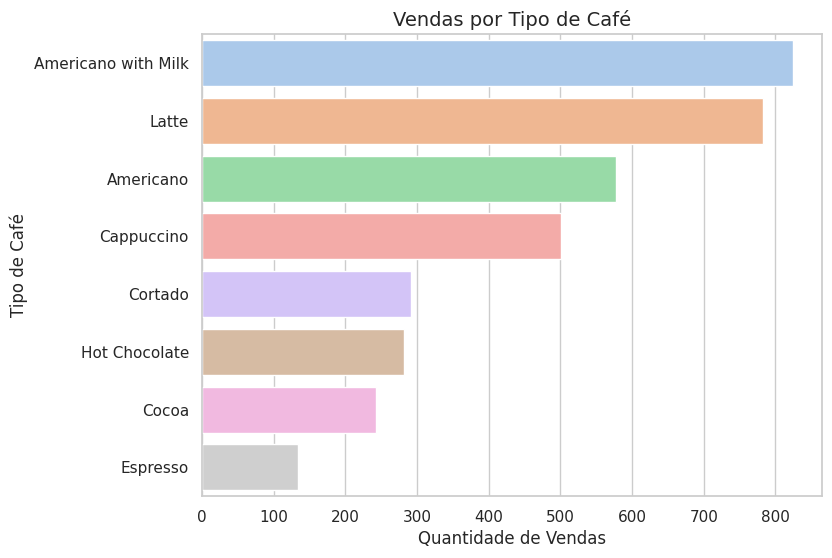

In [185]:
plt.figure(figsize = (8, 6))

sns.barplot(x = vendas_por_cafe.values,
            y = vendas_por_cafe.index,
            hue = vendas_por_cafe.index, # mantém cores diferentes para cada café
            palette = 'pastel')

plt.title('Vendas por Tipo de Café', fontsize=14)
plt.xlabel('Quantidade de Vendas')
plt.ylabel('Tipo de Café')
plt.show()

### Análise de Quantidade de Vendas por Produto

Os cafés mais vendidos no período foram:

- **Americano with Milk** – 824 unidades vendidas
- **Latte** – 782 unidades vendidas
- **Americano** – 578 unidades vendidas

Percebe-se que bebidas as bebidas mais populares indicam uma preferência dos clientes por bebidas mais tradicionais e possivelmente de preço mais acessível.

### 5.2 Análise de Produto: Faturamento por Tipo de Café

Nesta etapa, analiso o faturamento total de cada produto.  
Enquanto o gráfico anterior mostra a **quantidade de vendas**, aqui o objetivo é entender **quais cafés geram mais receita**, o que é útil para decisões de preço, mix de produtos e estratégias comerciais.

#### Total de Faturamento por Produto

In [186]:
faturamento_por_cafe = df1.groupby('coffee_name')['money'].sum().sort_values(ascending=False)
faturamento_por_cafe

,money
coffee_name,
Latte,27866.30
Americano with Milk,25269.12
Cappuccino,18034.14
Americano,15062.26
Hot Chocolate,10172.46
Cocoa,8678.16
Cortado,7534.86
Espresso,2814.28


#### Visualização: Faturamento por Produto

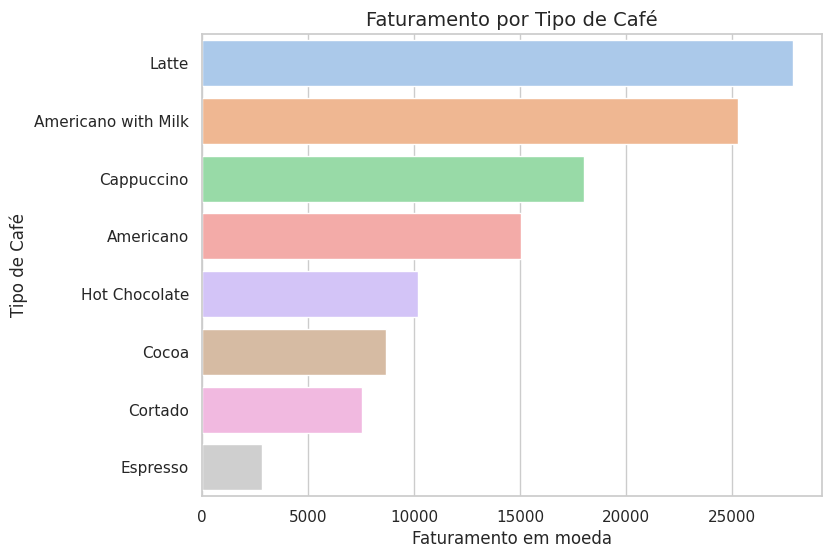

In [187]:
plt.figure(figsize=(8, 6))

sns.barplot(
    x=faturamento_por_cafe.values,
    y=faturamento_por_cafe.index,
    hue=faturamento_por_cafe.index,
    palette='pastel',
    legend=False)

plt.title('Faturamento por Tipo de Café', fontsize=14)
plt.xlabel('Faturamento em moeda')
plt.ylabel('Tipo de Café')
plt.show()

### Análise de Faturamento por Produto

Ao analisar o faturamento, observa-se que os produtos mais vendidos nem sempre são os que geram maior receita. Isso ocorre porque alguns cafés, mesmo vendendo menos unidades, possuem preços mais elevados, o que aumenta seu impacto no faturamento final.

Essas análises ajudam a identificar quais produtos são mais relevantes tanto em volume quanto financeiramente, servindo de base para decisões estratégicas de:

* Promoções
* Ajustes no mix de produtos
* Foco de marketing e vendas

### 5.3 Análise de Produto: Preço Médio por Produto (Ticket Médio)

A seguir, calculo do preço médio por tipo de café, seguido pela visualização gráfica.

#### Preço Médio por Produto

In [188]:
preco_medio_por_cafe = df1.groupby('coffee_name')['money'].mean().sort_values(ascending=False)
preco_medio_por_cafe.round(2)

,money
coffee_name,
Hot Chocolate,36.07
Cappuccino,36.00
Cocoa,35.71
Latte,35.63
Americano with Milk,30.67
Americano,26.06
Cortado,25.80
Espresso,21.00


#### Visualização: Preço Médio por Produto

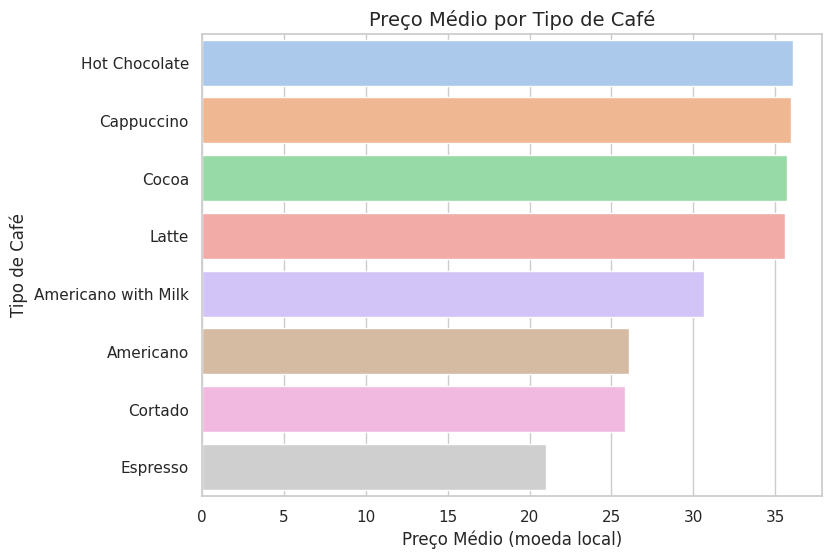

In [189]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x=preco_medio_por_cafe.values,     # valores do preço médio
    y=preco_medio_por_cafe.index,      # nomes dos cafés
    palette='pastel',
    hue=preco_medio_por_cafe.index,
    legend=False)

plt.title('Preço Médio por Tipo de Café', fontsize=14)
plt.xlabel('Preço Médio (moeda local)')
plt.ylabel('Tipo de Café')
plt.show()

#### Análise do Preço Médio por Produto

Para complementar a análise de quantidade e faturamento, calculo o preço médio pago por cada tipo de café.
Isso ajuda a entender o *ticket médio* e perceber se, por exemplo, cafés mais caros vendem menos, mas compensam no faturamento.

Apesar de não liderarem o ranking de volume, **Hot Chocolate** e **Cappuccino** possuem os maiores tickets médios, contribuindo proporcionalmente mais para o faturamento total.
Já o **Espresso**, com preço médio mais baixo, pode funcionar como um produto de entrada, atraindo novos clientes.


### 5.4 Análise Temporal: Vendas e Faturamentos Diários

A seguir, analisamos o **comportamento diário** das vendas e do faturamento. Essa visão é fundamental para identificar sazonalidade, picos específicos ou tendências ao longo do período analisado.

In [202]:
# Agrupar por dia e calcular vendas e faturamento
daily = (df1.groupby('day')
    .agg(vendas=('coffee_name', 'count'),
         faturamento=('money', 'sum')).reset_index())

daily

,day,vendas,faturamento
0,2024-03-01,11,396.30
1,2024-03-02,7,228.10
2,2024-03-03,10,349.10
3,2024-03-04,4,135.20
4,2024-03-05,9,338.50
...,...,...,...
376,2025-03-19,21,623.56
377,2025-03-20,20,597.60
378,2025-03-21,20,636.80
379,2025-03-22,12,365.42



#### Visualização: Vendas Diárias

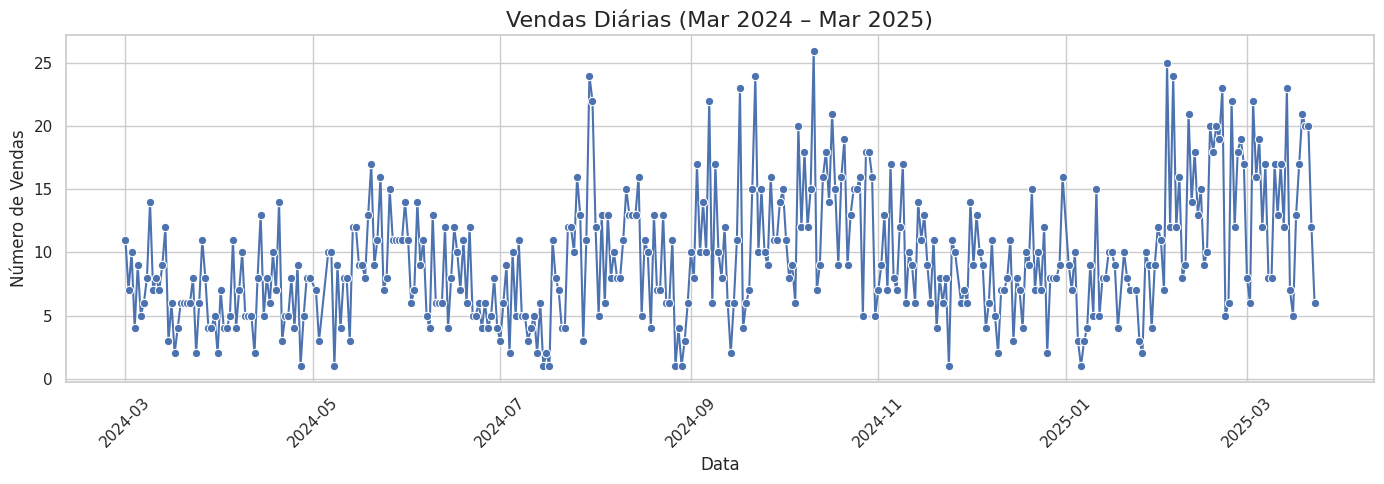

In [205]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=daily, x='day', y='vendas', marker='o')
plt.title('Vendas Diárias (Mar 2024 – Mar 2025)', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Número de Vendas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Visualização: Faturamento Diário

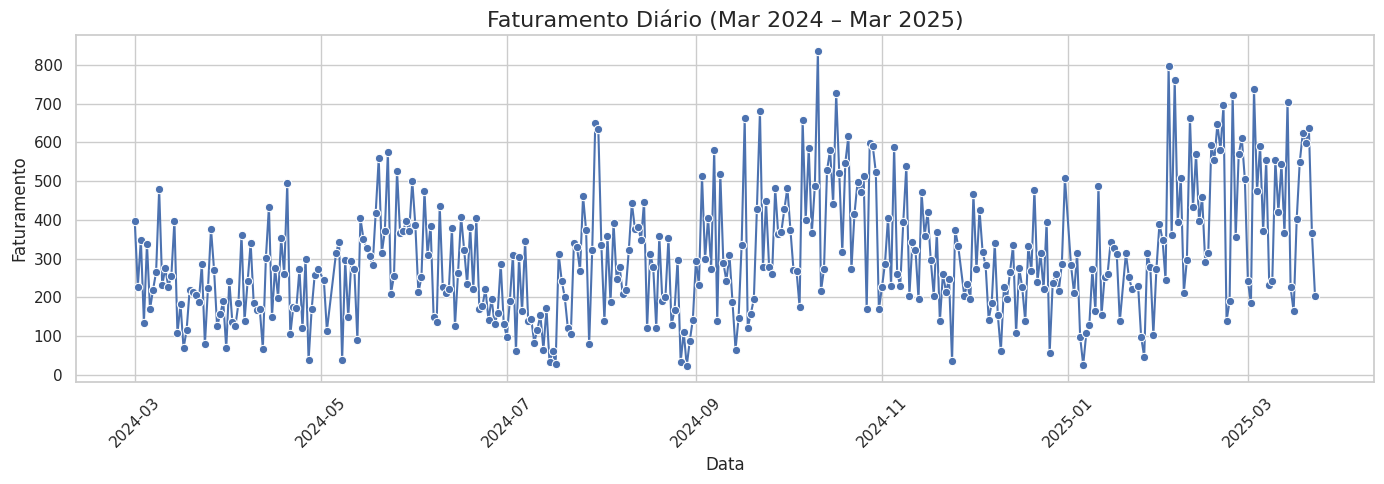

In [206]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=daily, x='day', y='faturamento', marker='o')
plt.title('Faturamento Diário (Mar 2024 – Mar 2025)', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Faturamento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Análise de Vendas e Faturamento Diários

Ao olhar os gráficos de séries diárias, percebemos:

- **Tendência de alta** nos últimos meses do período (início de 2025).  
- Um **pico expressivo** em **outubro de 2024**, possivelmente indicando um evento especial, campanha ou aumento sazonal.
- **Alta variabilidade diária**, com vendas e faturamento oscilando bastante, o que pode estar relacionado a clima, fins de semana, feriados ou promoções específicas.

 Esses padrões sugerem que pode ser interessante aprofundar a análise por **dia da semana** e **por mês**, para identificar períodos de maior desempenho e otimizar estratégias comerciais.

### 5.5 Análise Temporal: Vendas e Faturamento por Dia da Semana

Investigamos se há padrões recorrentes ao longo da semana (dias com maior movimento, tickets médios diferentes, etc).





In [222]:
# Agrupar por dia da semana e calcular médias
weekday_summary = (df1.groupby('weekday')
    .agg(vendas_médias=('coffee_name', 'count'),faturamento_médio=('money', 'mean'))
    .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])  # ordena
    .reset_index())
weekday_summary

,weekday,vendas_médias,faturamento_médio
0,Monday,561,31.952050
1,Tuesday,585,31.858769
2,Wednesday,510,31.555804
3,Thursday,520,31.687308
4,Friday,544,31.723640
5,Saturday,482,31.499004
6,Sunday,434,31.931014


#### Visualização: Média de Vendas por Dia da Semana

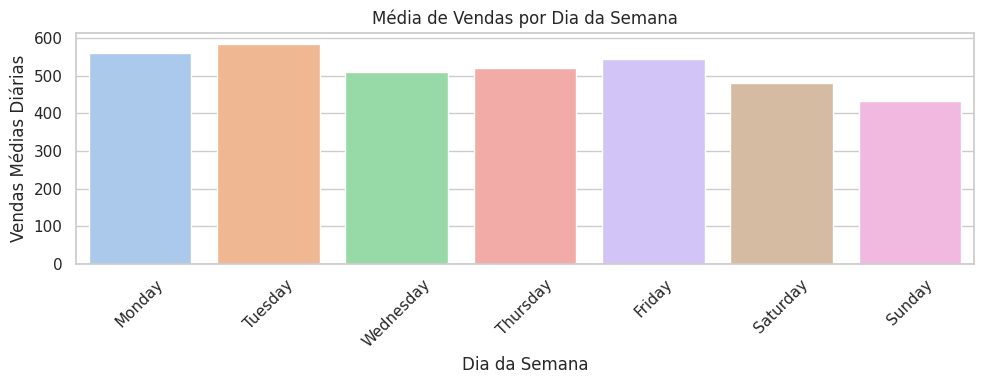

In [215]:
plt.figure(figsize=(10, 4))

weekdays = ['Monday', 'Tuesday', 'Wednesday',
                'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='weekday',
            y='vendas_médias',
            data=weekday_summary,
            hue='weekday',
            palette='pastel', order=weekdays, legend=False)
plt.title('Média de Vendas por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Vendas Médias Diárias')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Visualização: Faturamento Médio por Dia da Semana

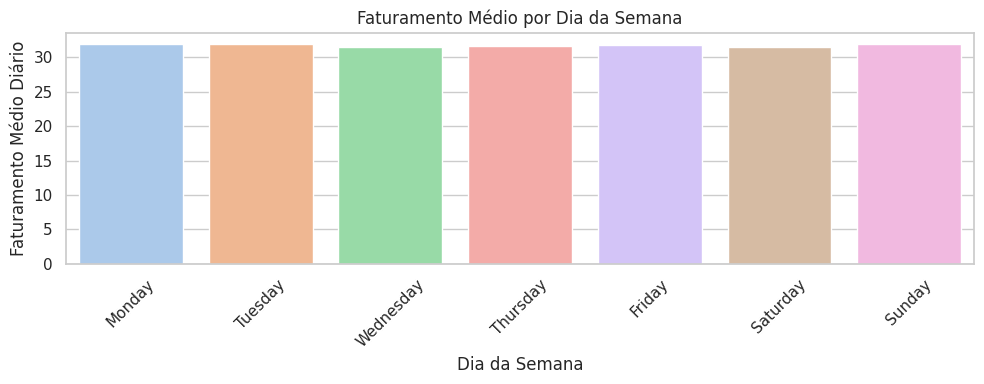

In [219]:
plt.figure(figsize=(10, 4))
weekdays = ['Monday', 'Tuesday', 'Wednesday',
                'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='weekday',
            y='faturamento_médio',
            data=weekday_summary,
            hue='weekday',
            palette='pastel', order=weekdays, legend=False)
plt.title('Faturamento Médio por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Faturamento Médio Diário')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Análise de Vendas e Faturamento por Dia da Semana

Para entender melhor as oscilações diárias, calculamos o total de vendas e o faturamento médio por cada dia da semana e os insights principais foram:

- **Terças-feiras** (585 vendas) e **segundas-feiras** (561 vendas) são os dias com maior volume de vendas.
- **Domingos** apresentam o menor volume de vendas (434).
- O **faturamento médio** por venda é bastante estável ao longo da semana (cerca de 31–32 unidades monetárias), mas **domingos** e **segundas** têm os tickets médios um pouco mais altos.

Esses padrões sugerem que ações promocionais podem ser usadas para reforçar vendas nos finais de semana, quando o movimento é menor.


### 5.6 Análise Temporal: Vendas e Faturamento Mensal

Agora observamos a evolução agregada por mês no período analisado.

In [223]:
monthly = (df1.groupby('month')
    .agg(vendas=('coffee_name', 'count'),faturamento=('money', 'sum'))
    .reset_index())
monthly.head()

,month,vendas,faturamento
0,2024-03-01,206,7050.20
1,2024-04-01,196,6720.56
2,2024-05-01,267,9063.42
3,2024-06-01,227,7758.76
4,2024-07-01,237,6915.94


#### Visualização: Vendas Mensais

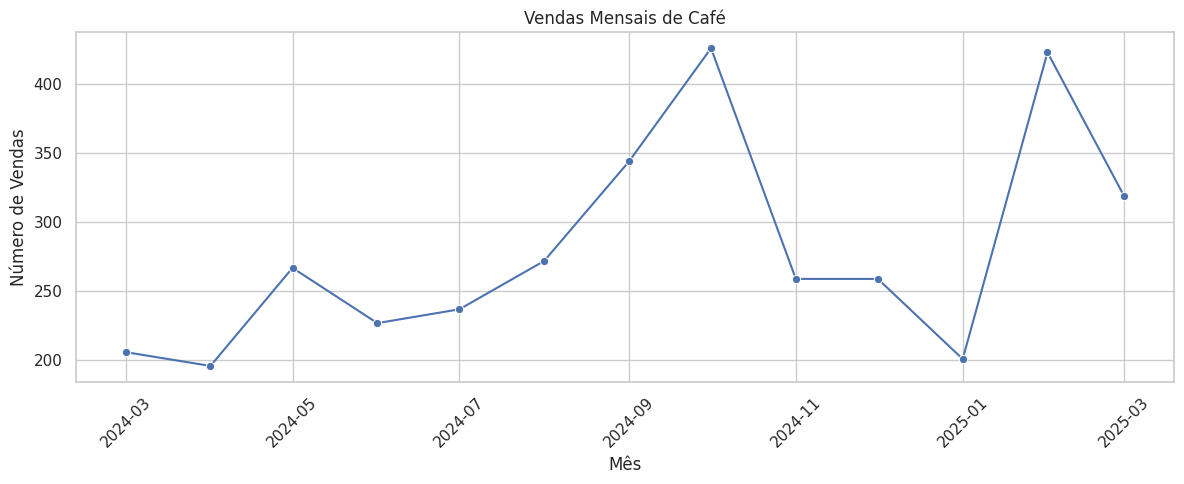

In [224]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly, x='month', y='vendas', marker='o')
plt.title('Vendas Mensais de Café')
plt.xlabel('Mês')
plt.ylabel('Número de Vendas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Visualização: Faturamento Mensal

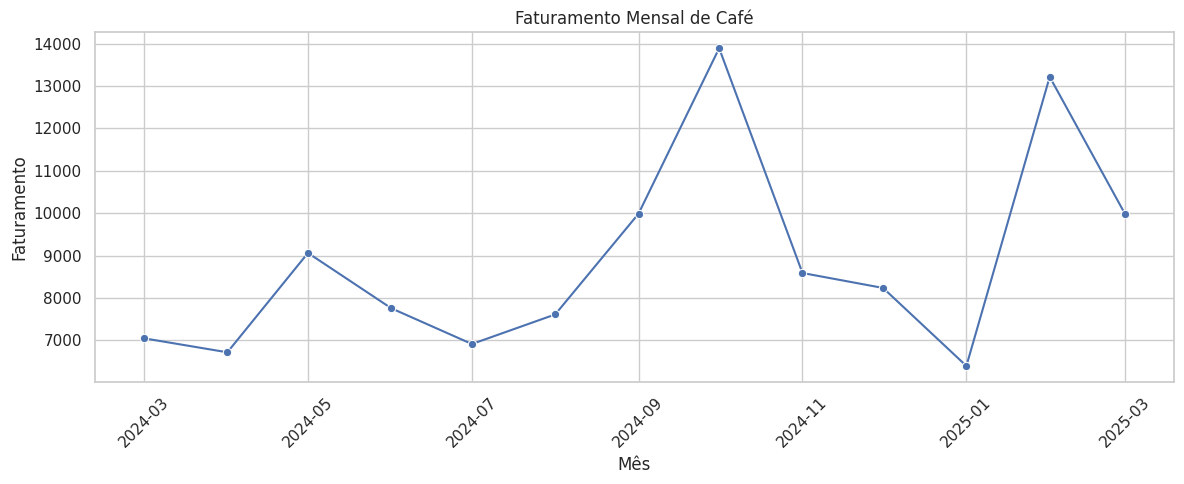

In [225]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly, x='month', y='faturamento', marker='o')
plt.title('Faturamento Mensal de Café')
plt.xlabel('Mês')
plt.ylabel('Faturamento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Análise de Vendas e Faturamento Mensal

Os insights dos gráficos de séries mensais mostram que:

* **Maio de 2024** foi o mês com melhor desempenho com 267 vendas e faturamento de 9.063,42.
* **Abril de 2024** teve o menor volume, apenas 196 vendas.
* **Junho** e **Julho** mostram estabilização após o pico de maio.
* Segundo pico em **Outubro de 2024**, consistente com a análise diária.

Esses comportamentos sugerem que replicar campanhas semelhantes às de maio e outubro pode melhorar meses mais fracos.

## Conclusão Geral e Recomendações

### Conclusão
O estudo apresentou uma visão completa do desempenho da cafeteria entre março de 2024 e março de 2025, considerando:

1. **Análise de Produtos**  
   - **Americano with Milk**, **Latte** e **Americano** são os campeões em volume de vendas e também estão entre os maiores faturamentos.  
   - **Cappuccino** e **Hot Chocolate** mesmo com volume menor, têm **ticket médio alto**, contribuindo de forma significativa para a receita.  
   - **Espresso* se destaca como item de entrada, com preço médio mais baixo e menor volume.

2. **Tendências Temporais**  
   - Pico de vendas e faturamento importantes: **maio e outubro de 2024**, indicando impacto de sazonalidades ou eventos especiais.  
   - Houve tendência de alta nos primeiros meses de 2025, sinalizando crescimento contínuo do negócio.  


3. **Desempenho Semanal e Mensal**  
   
   - **Terças-feiras** são o **melhor dia de vendas**.
   - Domingos têm o menor movimento.  
   - Os meses de menor venda (como abril)  podem receber ações para elevar o fluxo.

### Recomendações
1. **Promoções Sazonais**  
   - Planejar campanhas de marketing em torno de maio e outubro, aproveitando o histórico de picos de vendas.  
2. **Ofertas de “Porta de Entrada”**  
   - Destacar o *Espresso* em promoções de baixo custo para atrair novos clientes e incentivá-los a experimentar outras bebidas de maior ticket médio.  
3. **Campanhas Semanais**  
   - Oferecer descontos ou combos às terças-feiras (melhor dia de vendas) e ações especiais para atrair público aos domingos, quando o movimento é menor.  
4. **Análise de Eventos**  
   - Mapear feriados, datas comemorativas e eventos locais para replicar estratégias de sucesso em outros períodos do ano.  
5. **Acompanhamento Contínuo**  
   - Automatizar relatórios mensais para monitorar vendas e faturamento e ajustar rapidamente as ações de marketing.

---

### Próximos passos

Para evoluir o projeto:

> Integrar dados de custo para calcular margem de lucro por produto.  
> Analisar perfil de clientes utilizando a coluna `card` para campanhas de fidelização.  
> Explorar correlações com variáveis externas (clima, eventos) para refinar previsões de demanda.  






